# Bayesian inference example
A campaign on fb where clicks of users on the ad are success and not clicking is failure
The ad has been presented to 10 users so far, and 7 of the users have clicked on it. We would like to estimate the probability that the next user will click on the ad. 

In [1]:
# import libraries
import numpy as np,pandas as pd
from scipy.misc import factorial
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16,7)

In [2]:
# functions
def BinomialDistProb(theta, n, x):
    """
    BinomialDistProb function for a binomial distribution
    n: [int] the number of experiments
    x: [int] the number of successes
    theta: [float] the proposed probability of success
    return prob. for given inputs
    """
    return (factorial(n) / (factorial(x) * factorial(n - x))) \
            * (theta ** x) * ((1 - theta) ** (n - x))

In [3]:
# variables
#the number of impressions for our facebook-yellow-dress campaign
n_impressions = 10.
#the number of clicks for our facebook-yellow-dress campaign
n_clicks = 7.
#observed click through rate
ctr = n_clicks / n_impressions

In [4]:
#0 to 1, all possible click through rates
possible_theta_valuesTemp =  list(range(0,100))
possible_theta_values = [x / 100 for x in possible_theta_valuesTemp]
print(possible_theta_values[:10])

[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]


#### get likelihood function for binomial distribution; prob that 7 users out of 10 will open facebook ad given the theta value

In [5]:
likelihoods = []
for item in possible_theta_values:
    likelihoods.append(BinomialDistProb(item,10,7))
print(likelihoods[:10])

[0.0, 1.1643588000000002e-12, 1.445670912e-10, 2.3952190211999993e-09, 1.73946175488e-08, 8.037890625000001e-08, 2.7901243514879987e-07, 7.949070922212003e-07, 1.9596325158912004e-06, 4.325168078758799e-06]


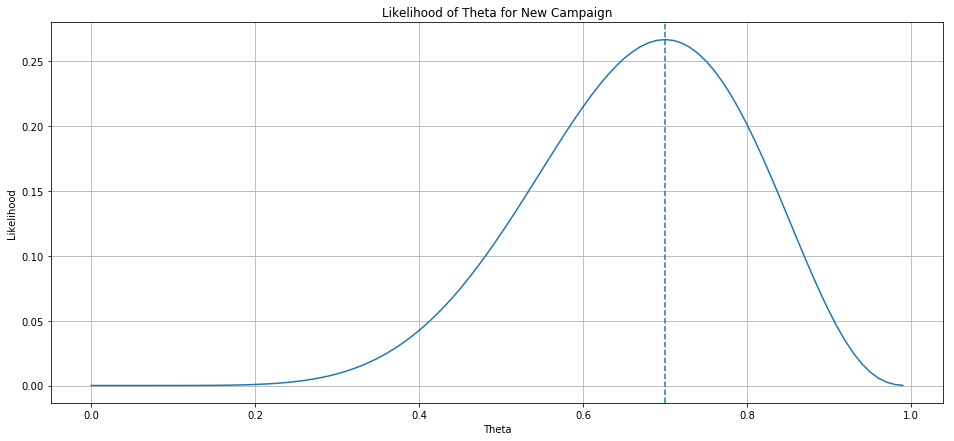

In [6]:
#theta with the most likelihood= 0.7; 7 out of 10 clients clicked the ad
mle = possible_theta_values[np.argmax(likelihoods)]
#plot
f, ax = plt.subplots(1)
ax.plot(possible_theta_values, likelihoods)
ax.axvline(mle, linestyle = "--")
ax.set_xlabel("Theta")
ax.set_ylabel("Likelihood")
ax.grid()
ax.set_title("Likelihood of Theta for New Campaign")
plt.show()

## Add previous campaigns results

#### overlay this likelihood function with distribution of click-through rates from our previous 100 campaigns

In [7]:
# randomly generate "true" clicks from beta distribution,
# 100 random samples(theta) from beta distribution 
theta_old = np.random.beta(11.5,48.5,size=100)
print(theta_old[:10])

[0.21888664 0.14767007 0.24491828 0.22718208 0.15308333 0.165827
 0.29860164 0.12264345 0.08396123 0.1770707 ]


In [8]:
# randomly generate corresponding number of user observations for each campaign
impressions_old = np.random.randint(1,10000,size=100)
print(impressions_old[:10])

[5906 4087 1308 2515 2621 9427 3455 9673 5783  389]


In [9]:
# sample no of clicks for each campaign
clicks_old = np.random.binomial(impressions_old,theta_old).astype(float)
np.set_printoptions(precision=4)
print(clicks_old[:10])

[1252.  630.  309.  579.  371. 1578. 1046. 1211.  486.   66.]


### Previous campaigns vs current campaign

#### likelihood of every old campaign's theta corresponds to the prior probability; we believe that certain values of theta are more likely than others

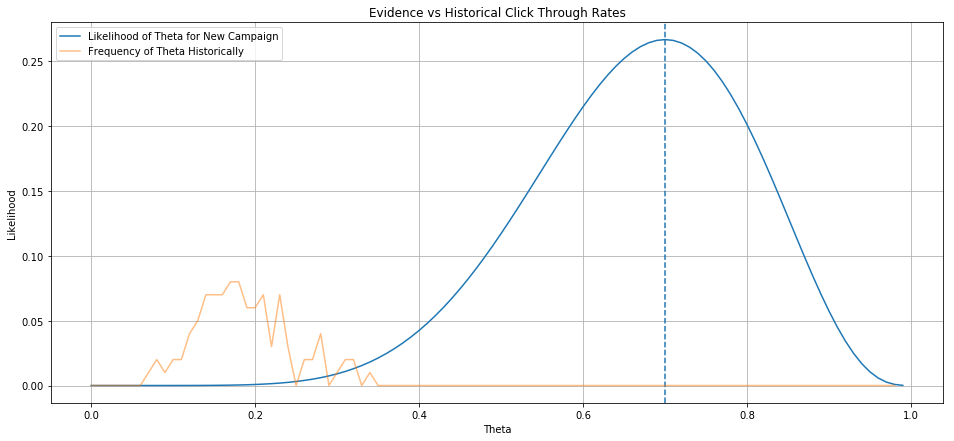

In [10]:
#plot the histogram of previous click through rates with the evidence#of the new campaign
f, ax = plt.subplots(1)
ax.axvline(mle, linestyle = "--")
ax.plot(possible_theta_values, likelihoods)
zero_to_one = [j/100. for j in range(100)]
counts, bins = np.histogram((clicks_old/impressions_old)
                            , bins=zero_to_one)
counts = counts / 100.
ax.plot(bins[:-1],counts, alpha = .5)
line1, line2, line3 = ax.lines
ax.legend((line2, line3), ('Likelihood of Theta for New Campaign'
                           , 'Frequency of Theta Historically')
                          , loc = 'upper left')
ax.set_xlabel("Theta")
ax.set_ylabel("Likelihood")
ax.grid()
ax.set_title("Evidence vs Historical Click Through Rates")
plt.show()

#### Choosing beta distribution as a prior for theta, we will fit the beta distribution to the old campaign data to get the distribution parameters (alpha,beta)

In [11]:
from scipy.stats import beta
#fit beta to previous CTRs
prior_parameters = beta.fit(theta_old, floc = 0, fscale = 1)

In [12]:

#extract alpha,beta from fit
alpha, betavar = prior_parameters[0:2]
#create prior distribution sample from prior
prior_distribution = beta(alpha, betavar)
#get histogram of 10000 samples
prior_samples = prior_distribution.rvs(10000)
#get histogram of samples
fit_counts, bins = np.histogram(prior_samples
                                , zero_to_one)
# normalize histogram
normalized_fit_counts = []
for item in fit_counts:
    normalized_fit_counts.append(float(item)/sum(fit_counts))  
print(normalized_fit_counts[:10])


[0.0, 0.0, 0.0, 0.0002, 0.0002, 0.0012, 0.0019, 0.0055, 0.0081, 0.0149]


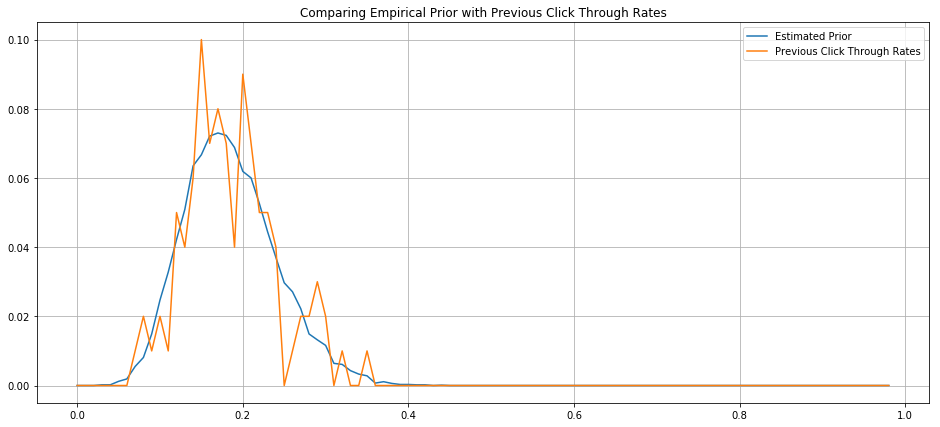

In [13]:
#plot
f, ax = plt.subplots(1)
ax.plot(bins[:-1], normalized_fit_counts)
hist_ctr, bins = np.histogram(theta_old
                              , zero_to_one)
hist_ctr = hist_ctr[:]/np.sum(hist_ctr)
ax.plot(bins[:-1], hist_ctr)
estimated_prior, previous_click_through_rates = ax.lines
ax.legend((estimated_prior, previous_click_through_rates)
          ,('Estimated Prior'
            , 'Previous Click Through Rates'))
ax.grid()
ax.set_title("Comparing Empirical Prior with Previous Click Through Rates")
plt.show()

# Using PyMC to estimate posterior prob

In [14]:
import pymc3 as pm
#clicks represents our successes. We observed 7 clicks.
clicks = np.array([n_clicks])
#this represents the number of trials. There were 10 impressions.
impressions = np.array([n_impressions])
# create pymc model object and established context manager;
# all pymc objects created within will be added to the 
# model object
with pm.Model() as model:
#sets a context; all code in block "belongs" to the model object
    #our prior distribution
    theta_prior = pm.Beta('prior', 11.5, 48.5)
    #Sampling distribition of outcomes in the dataset.
    #our prior p_prior will be updated with data
    observations = pm.Binomial('obs',n = impressions
                               , p = theta_prior
                               , observed = clicks)
    #Max Aposterior values, or values that are most likely
    # maximizes joint likelihood function (posterior)
    start = pm.find_MAP()    
    #Choose a particular MCMC algorithm (sampling algorithm)
    # which defines how proposing new samples given our current
    # state
    #we'll choose NUTS, the No U-Turn Sampler (Hamiltonian)
    step = pm.NUTS()     
    trace = pm.sample(5000
                      , step
                      , start=start
                      , progressbar=True)               #obtain samples

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
logp = -5.3618, ||grad|| = 4.4667: 100%|█████████████████████████████████████████████| 7/7 [00:00<00:00, 999.39it/s]
C:\ProgramData\Anaconda3\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior_logodds__]


#### The data has caused us to believe that the true click-through rate is higher than we originally thought, but far lower than the 0.7 click-through rate observed so far from the facebook-yellow-dress campaign. Why is this the case? Note how wide our likelihood function is; it's telling us that there is a wide range of values of θ under which our data is likely. If the range of values under which the data were plausible were narrower, then our posterior would have shifted further

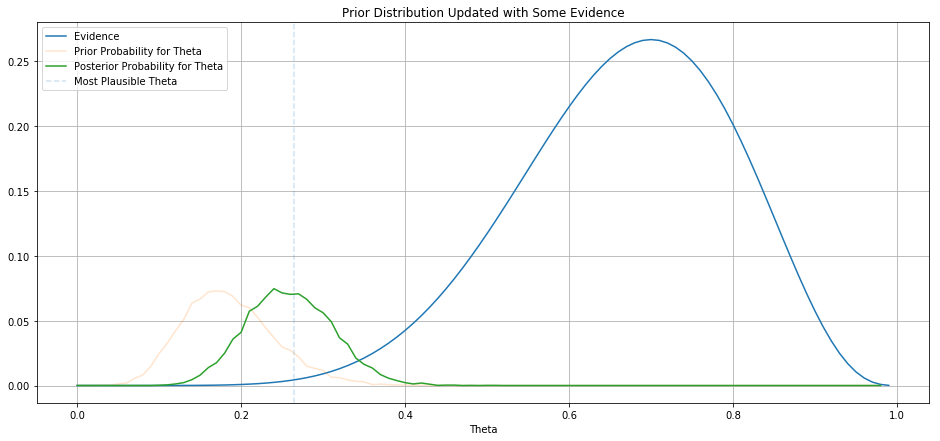

In [15]:
#plot the histogram of click through rates
plt.rcParams['figure.figsize'] = (16, 7)
#get histogram of samples from posterior distribution of CTRs
posterior_counts, posterior_bins = np.histogram(trace['prior']
                                                ,bins=zero_to_one)
#normalized histogram
posterior_counts = posterior_counts / float(posterior_counts.sum())
#take the mean of the samples as most plausible value
most_plausible_theta = np.mean(trace['prior'])
#histogram of samples from prior distribution
prior_counts, bins = np.histogram(prior_samples
                                  , zero_to_one)#normalize
prior_counts = prior_counts[:]/np.sum(prior_counts)
#plot
f, ax = plt.subplots(1)
ax.plot(possible_theta_values, likelihoods)
ax.plot(bins[:-1],prior_counts, alpha = .2)
ax.plot(bins[:-1],posterior_counts)
ax.axvline(most_plausible_theta, linestyle = "--", alpha = .2)
line1, line2, line3, line4 = ax.lines
ax.legend((line1, line2, line3, line4), ('Evidence'
                                         , 'Prior Probability for Theta'
                                         , 'Posterior Probability for Theta'
                                         , 'Most Plausible Theta'
                                        ), loc = 'upper left')
ax.set_xlabel("Theta")
ax.grid()
ax.set_title("Prior Distribution Updated with Some Evidence")
plt.show()

#### See what happens to the posterior if we observed a 0.7 click-through rate from 10, 100, 1,000, and 10,000 impressions

In [16]:
import pymc3 as pm
import numpy as np

#create our data:
traces = {}
for ad_impressions in [10, 100, 1000, 10000]: #maintaining observed CTR of 0.7
    clicks = np.array([ctr * ad_impressions])    #re-estimate the posterior for
    impressions = np.array([ad_impressions])    #increasing numbers of impressions
    with pm.Model() as model:
        theta_prior = pm.Beta('prior', 11.5, 48.5)
        observations = pm.Binomial('obs',n = impressions
                                   , p = theta_prior
                                   , observed = clicks)
        start = pm.find_MAP()
        step = pm.NUTS()
        trace = pm.sample(5000
                          , step
                          , start=start
                          , progressbar=True)

        traces[ad_impressions] = trace


logp = -5.3618, ||grad|| = 4.4667: 100%|████████████████████████████████████████████| 7/7 [00:00<00:00, 1398.43it/s]
C:\ProgramData\Anaconda3\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior_logodds__]
logp = -61.328, ||grad|| = 50.217: 100%|████████████████████████████████████████████| 7/7 [00:00<00:00, 1165.73it/s]
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior_logodds__]
logp = -610.91, ||grad|| = 507.72: 100%|████████████████████████████████████████████| 8/8 [00:00<00:00, 1141.58it/s]
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior_logodds__]
logp = -6,096.4, ||grad|| = 5,082.7: 100%|██████████████████████████████████████████| 9/9 [00:00<00:00, 1284.76it/s]
Multiprocess sampling (2 chains in 2 jobs)
NUTS

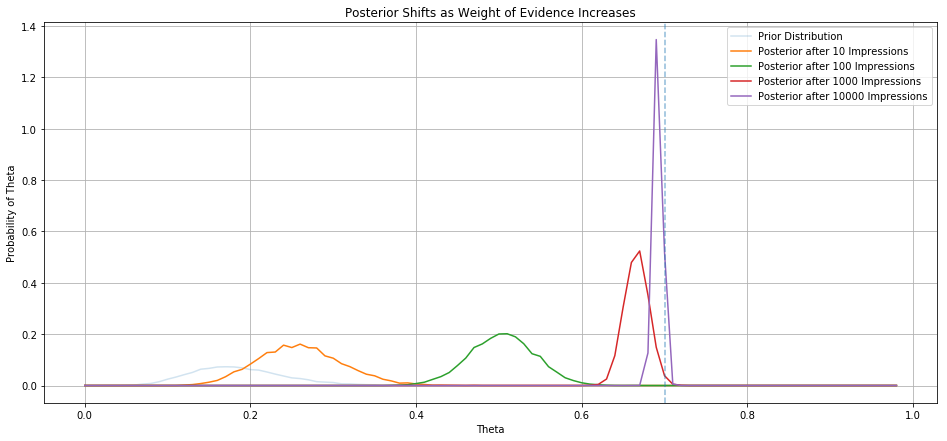

In [17]:
f, ax = plt.subplots(1)
ax.plot(bins[:-1],prior_counts, alpha = .2)

counts = {}
for ad_impressions in [10, 100, 1000, 10000]:
    trace = traces[ad_impressions]
    posterior_counts, posterior_bins = np.histogram(trace['prior'], bins=[j/100. for j in range(100)])
    posterior_counts = posterior_counts / float(len(trace))
    ax.plot(bins[:-1], posterior_counts)
line0, line1, line2, line3, line4 = ax.lines
ax.legend((line0, line1, line2, line3, line4), ('Prior Distribution'
                                                ,'Posterior after 10 Impressions'
                                                , 'Posterior after 100 Impressions'
                                                , 'Posterior after 1000 Impressions'
                                                ,'Posterior after 10000 Impressions'))
ax.set_xlabel("Theta")
ax.axvline(ctr, linestyle = "--", alpha = .5)
ax.grid()
ax.set_ylabel("Probability of Theta")
ax.set_title("Posterior Shifts as Weight of Evidence Increases")
plt.show()

#### As we obtain more and more data, we are more certain that the 0.7 success rate is the true success rate. Conditioning on more data as we update our prior, the likelihood function begins to play a larger role in our ultimate assessment because the weight of the evidence gets stronger. This would be particularly useful in practice if we wanted a continuous, fair assessment of how our campaigns are performing without having to worry about overfitting to a small sample.